<a target="_blank" href="https://colab.research.google.com/github/CPeti/ALPR/blob/main/yolo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Using YOLOv5 for bounding box detection

In [7]:
import yolov5
import os
import random
from PIL import Image

In [8]:
# load model
model = yolov5.load('keremberke/yolov5m-license-plate')

YOLOv5  2023-11-26 Python-3.10.10 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [9]:
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1  # maximum number of detections per image

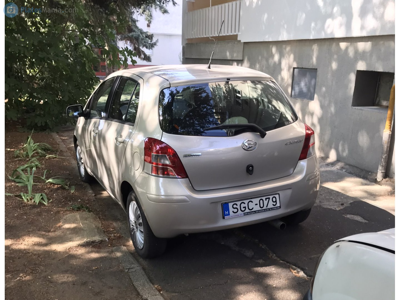

In [91]:
# set image
files = os.listdir("./data/images_new/")
img = Image.open("./data/images_new/" + random.choice(files))
#show image in notebook
img.resize((400, 300))

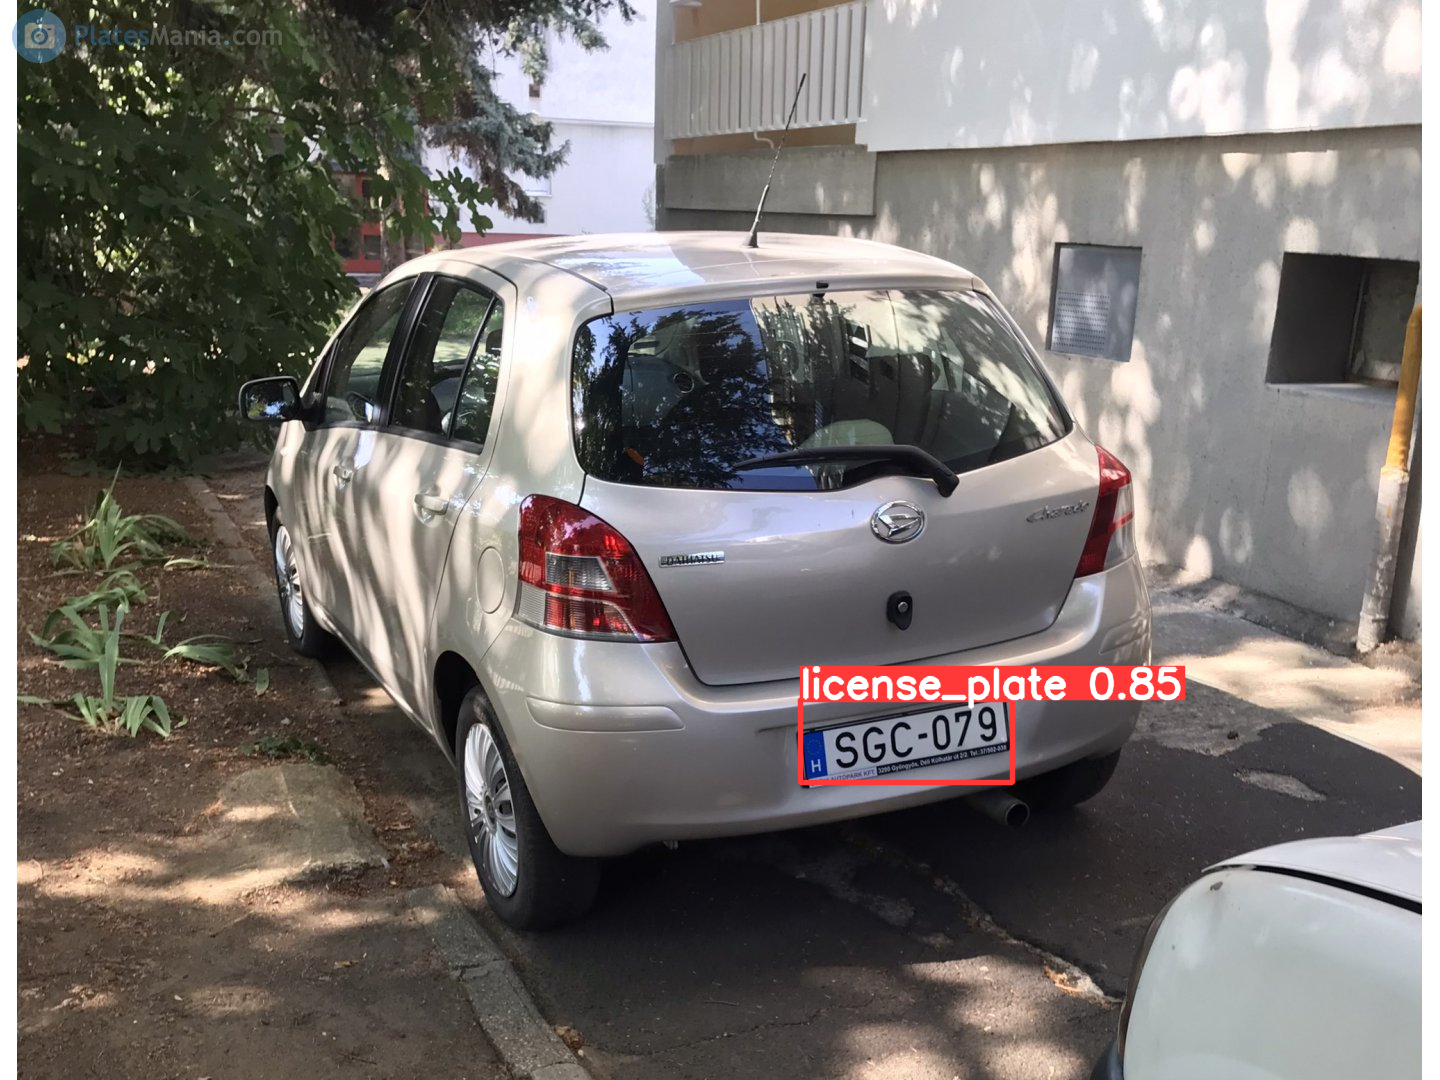

In [92]:
# perform inference
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
#results.save(save_dir='./results/result')

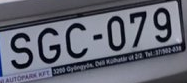

In [93]:
# crop detected license plates
boxes = boxes.numpy()
cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
#crop left 12%
cropped = cropped.crop((cropped.width * 0.12, 0, cropped.width, cropped.height))
cropped

# Perform OCR on cropped plate

In [13]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

In [14]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
pixel_values = processor(cropped, return_tensors="pt").pixel_values
generated_ids = ocr_model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [16]:
generated_text

'AAOHW-430'

## Putting the two parts together

In [180]:
def filter_plate(generated_text):
    generated_text = generated_text.replace(".", " ").replace("*", " ").replace("@", " ").replace(":", "-").replace("]", "").replace("[", "").replace(")", "").replace("(", "").replace(";", "") \
                                   .replace("!", "1").replace("?", "7").replace("§", "5").replace("€", "6").replace("=", "").replace("ß", "8").replace("ü", "4").replace("ö", "3").replace("ä", "2") \
                                   .replace("„", "").replace("“", "").replace("’", "").replace("‘", "").replace("´", "").replace("°", "").replace("¨", "").replace("/", "").replace("\\", "").replace("|", "") \
                                   .replace(">", "").replace("<", "").replace("  ", " ") #ugly but works
    #check if license plate is valid and fix if possible
    if len(generated_text) > 3:
        if generated_text[0] == ' ':
            generated_text = generated_text[1:]
        if generated_text[2] == '-':
            generated_text = generated_text[0:2] + ' ' + generated_text[3:]
    if '-' not in generated_text:
        #check if license_plate is missing separator
        if len(generated_text) == 6 and generated_text[0].isalpha() and generated_text[1].isalpha() and generated_text[2].isalpha() and generated_text[3].isdigit() and generated_text[4].isdigit() and generated_text[5].isdigit():
            generated_text = generated_text[0:3] + '-' + generated_text[3:]
            #print("Attempted to fix license plate")
        elif len(generated_text) == 7 and generated_text[0].isalpha() and generated_text[1].isalpha() and generated_text[2].isalpha() and generated_text[4].isdigit() and generated_text[5].isdigit() and generated_text[6].isdigit():
            generated_text = generated_text[0:3] + '-' + generated_text[4:]
        elif len(generated_text) > 4 and generated_text[0].isalpha() and generated_text[1].isalpha() and generated_text[2] == ' ' and generated_text[-1].isdigit() and generated_text[-2].isdigit() and generated_text[-3].isdigit():
            if generated_text[-4] == ' ':
                generated_text = generated_text[:-4] + '-' + generated_text[-3:]
            else:
                generated_text = generated_text[:-3] + '-' + generated_text[-3:]
        else:
            #print("Invalid license plate")
            pass
    parts = generated_text.split('-')
    if len(parts) >= 2:
        chars = parts[0]
        numbers = parts[1]#
        if len(chars) > 1:
            if chars[0] == ' ':
                chars = chars[1:]
            if chars[-1] == ' ':
                chars = chars[:-1]
        if len(chars) == 3 and len(numbers) == 3:
            chars = chars.replace('1', 'I')
        generated_text = chars + '-' + numbers
        if len(chars) == 3 and len(numbers) == 3:
            #print("Valid license plate")
            pass
        elif ' ' in chars and len(chars) == 5 and len(numbers) == 3:
            if not chars[0].isalpha() and not chars[1].isalpha():
                generated_text = generated_text[2:]
            #print("Valid license plate")
            pass
        elif len(chars) == 5 and len(numbers) == 3:
            if chars[2] != ' ' and chars[0].isalpha() and chars[1].isalpha():
                generated_text = chars[0:2] + ' ' + chars[3:] + '-' + numbers
        elif ' ' not in chars and len(chars) == 4 and (len(numbers) == 3 or len(numbers) == 2): #fix case when OCR detects country sign as part of license plate
            if (generated_text[0] == 'A' and generated_text[1] == 'A') or (generated_text[0] == 'O' and generated_text[1] == 'T'):
                generated_text = generated_text[0:2] + ' ' + generated_text[2:] #new plate format, we are only at AA (little cheating here)
            else:
                generated_text = generated_text[1:]
            #print("Attempted to fix license plate")
    return generated_text
    

In [181]:
def detect_license_plate(img):
    # inference with test time augmentation
    results = model(img, augment=True)

    # parse results
    predictions = results.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    if len(boxes) == 0:
        #print("No license plate detected")
        return "" #no license plate detected
    # crop detected license plates
    boxes = boxes.numpy()
    cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
    #crop left 11% of image
    cropped = cropped.crop((cropped.width * 0.11, 0, cropped.width, cropped.height))

    # perform OCR
    pixel_values = processor(cropped, return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #some filtering for misdetected characters
    generated_text = filter_plate(generated_text)
    return generated_text

expected: LTS-380
detected: LTS-380


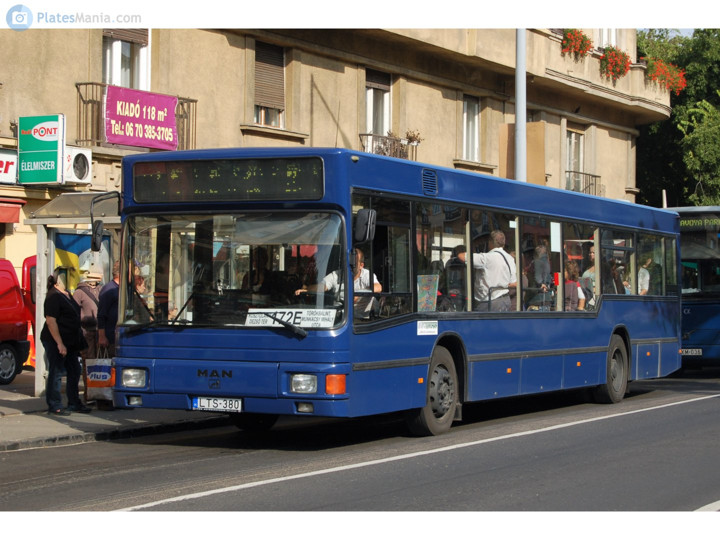

In [190]:
#load random image from test set
files = os.listdir("./data/images_new/")
choice = random.choice(files)
img = Image.open("./data/images_new/" + choice)

plate = detect_license_plate(img)
# show image and OCR result
print("expected: " + choice.split('.')[0])
print("detected: " + plate)
#resize image to 50% of original size
img.resize((int(img.width * 0.5), int(img.height * 0.5)))

In [ ]:
#calculate accuracy
correct = 0
wrong = 0
i = 0
#shuffle files
random.shuffle(files)
for file in files:
    img = Image.open("./data/images_new/" + file)
    plate = detect_license_plate(img)
    if plate == file.split('.')[0]:
        correct += 1
    else:
        wrong += 1
        print(file.split('.')[0], plate)
    i += 1
    if i % 100 == 0:
        print("Progress: " + str(i) + "/" + str(len(files)))
        print("Accuracy: " + str(correct / (correct + wrong)))
    if i == 1000:
        break

In [ ]:
print("Correct: " + str(correct))
print("Wrong: " + str(wrong))
print("Accuracy: " + str(correct / (correct + wrong)))

Our model performs pretty good overall, however during evaluation we have identified some problems. The OCR model frequently confuses '0', 'O' and 'Q' characters, and has a tendency to detect the edge of the plate as an additional character. We try to filter these, but its not always possible. Another source of mistakes is the plate detector not recognizing plates in the image, or recognizing a wrong plate or text on the back of a car. Our dataset is supposed to have images with only one plate visible, but this is not always the case. The OCR model also has problems recognizing tall plates on bikes and buses.

The model is also extremely slow, using TrOCR is overkill for this task

### Example for wrong detection:

In [ ]:
img = Image.open("./data/images_new/DJX-072.jpg")
plate = detect_license_plate(img)
print(plate)

 PZ


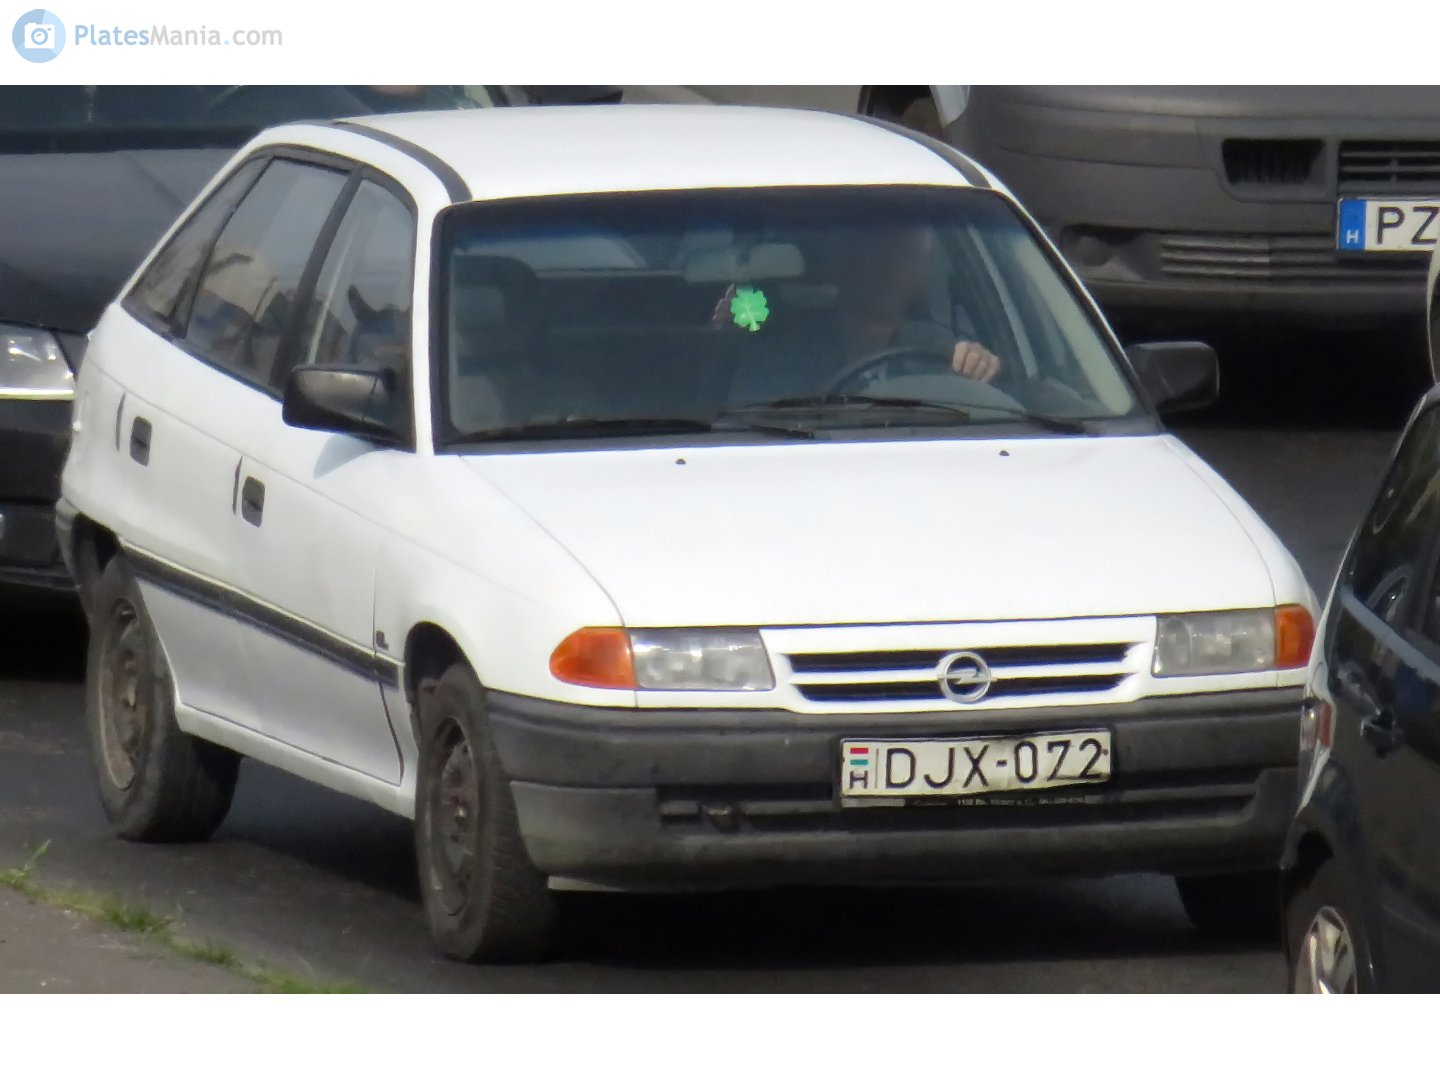

In [ ]:
img.resize((int(img.width * 0.5), int(img.height * 0.5)))

# Using pytesseract for OCR

much faster than TrOCR, however less accurate

In [21]:
import pytesseract

In [22]:
path_to_tesseract = r"D:\programs\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = path_to_tesseract

In [194]:
def detect_license_plate_with_tesseract(img):
    # inference with test time augmentation
    results = model(img, augment=True)

    # parse results
    predictions = results.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    if len(boxes) == 0:
        #print("No license plate detected")
        return "" #no license plate detected
    # crop detected license plates
    boxes = boxes.numpy()
    cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
    #crop left 11% of image
    cropped = cropped.crop((cropped.width * 0.11, 0, cropped.width, cropped.height))

    # Save the image to a temporary file
    temp_file = "temp.png"
    cropped.save(temp_file)

    # Reopen the image as a PngImageFile
    png_img = Image.open(temp_file)
    generated_text = pytesseract.image_to_string(png_img, lang="eng", config ='--oem 1 --psm 13 -c tessedit_char_whitelist=-ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    generated_text = generated_text[:-1]
    generated_text = filter_plate(generated_text)
    
    return generated_text

expected: LTS-380
detected: LTS-380


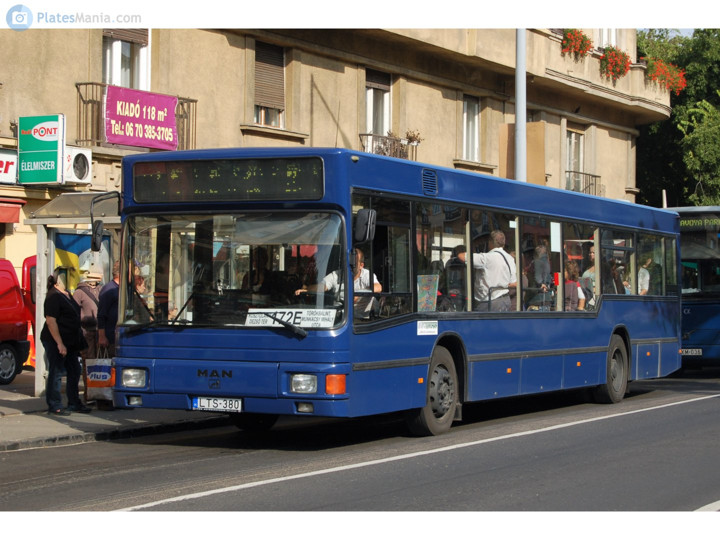

In [189]:
#load random image from test set
files = os.listdir("./data/images_new/")
choice = random.choice(files)
img = Image.open("./data/images_new/" + choice)

plate = detect_license_plate_with_tesseract(img)
# show image and OCR result
print("expected: " + choice.split('.')[0])
print("detected: " + plate)
#resize image to 50% of original size
img.resize((int(img.width * 0.5), int(img.height * 0.5)))

OCR with pytesseract is about 5 times faster than TrOCR, but much less accurate

In [195]:
#compare pytesseract with trocr
for _ in range(5):
    files = os.listdir("./data/images_new/")
    choice = random.choice(files)
    img = Image.open("./data/images_new/" + choice)
    #img = Image.open("./data/images_new/SGC-079.jpg")

    plate_tesseract = detect_license_plate_with_tesseract(img)
    plate_trocr = detect_license_plate(img)
    # show image and OCR result
    print("expected: " + choice.split('.')[0])
    print("detected with tesseract: " + plate_tesseract)
    print("detected with trocr: " + plate_trocr)
    print("")

expected: RPL-815
detected with tesseract: RPL-815
detected with trocr: RPL-815

expected: AA FZ-137
detected with tesseract: NEZ-197
detected with trocr: AAOF Z-137

expected: SFK-529
detected with tesseract: SFK-529
detected with trocr: SFK-529

expected: PXV-246
detected with tesseract: PXV-246
detected with trocr: PXV-246

expected: HBT-943
detected with tesseract: HBT-973
detected with trocr: HBT-943



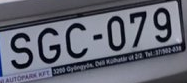

In [196]:
cropped

In [197]:
temp_file = "temp.png"
cropped.save(temp_file)

# Improving pytesseract performance with oldschool image processing techniques

In [327]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border

CU-299
CIJ-292


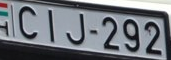

In [412]:
files = os.listdir("./data/images_new/")
choice = random.choice(files)
img = Image.open("./data/images_new/" + choice)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
# crop detected license plates
boxes = boxes.numpy()
cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
#crop left 5% of image
cropped = cropped.crop((cropped.width * 0.05, 0, cropped.width, cropped.height))

# Save the image to a temporary file
temp_file = "temp.png"
cropped.save(temp_file)

plate = cv2.imread(temp_file)
#to grayscale
plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

roi = cv2.threshold(plate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#invert image
#roi = cv2.bitwise_not(roi)
cleared = clear_border(roi)
#save as image
cv2.imwrite("clear_border.png", cleared)
#clear noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
opening = cv2.morphologyEx(cleared, cv2.MORPH_OPEN, kernel, iterations=1)
#save as image
cv2.imwrite("opening.png", opening)

text = pytesseract.image_to_string(opening, lang="eng", config ='--oem 1 --psm 6 -c tessedit_char_whitelist=-ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
print(text[:-1])
print(choice.split('.')[0])
cropped

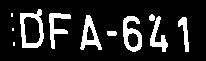

In [373]:
#show opening
img = Image.open("opening.png")
img

### Boosting OCR accuracy with some preprocessing should work with TrOCR aswell, but making it even slower

In [397]:
def detect_license_plate_with_preprocess(img):
    # inference with test time augmentation
    results = model(img, augment=True)

    # parse results
    predictions = results.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    if len(boxes) == 0:
        #print("No license plate detected")
        return "" #no license plate detected
    # crop detected license plates
    boxes = boxes.numpy()
    cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
    #crop left 5% of image
    cropped = cropped.crop((cropped.width * 0.10, 0, cropped.width, cropped.height))

    # Save the image to a temporary file
    temp_file = "temp.png"
    cropped.save(temp_file)

    plate = cv2.imread(temp_file)
    #to grayscale
    plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    roi = cv2.threshold(plate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #roi = cv2.bitwise_not(roi)
    cleared = clear_border(roi)
    #to rgb
    cleared = cv2.cvtColor(cleared, cv2.COLOR_GRAY2RGB)
    #save as image
    cv2.imwrite("out.png", cleared)

    #open image again
    img = Image.open("out.png")

    # perform OCR
    pixel_values = processor(img, return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #some filtering for misdetected characters
    generated_text = filter_plate(generated_text)
    return generated_text

expected: CIJ-292
detected with tesseract: CJ-299
detected with trocr: CLJ-292
detected with preprocess: CIJ-292


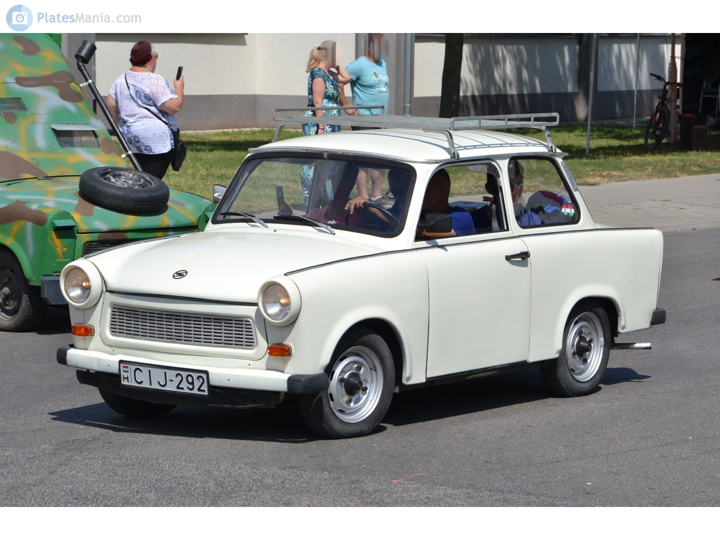

In [411]:
#load random image from test set
files = os.listdir("./data/images_new/")
choice = random.choice(files)
img = Image.open("./data/images_new/" + choice)

plate = detect_license_plate_with_preprocess(img)
plate_tesseract = detect_license_plate_with_tesseract(img)
plate_trocr = detect_license_plate(img)
# show image and OCR result
print("expected: " + choice.split('.')[0])
print("detected with tesseract: " + plate_tesseract)
print("detected with trocr: " + plate_trocr)
print("detected with preprocess: " + plate)
#resize image to 50% of original size
img.resize((int(img.width * 0.5), int(img.height * 0.5)))

Sometimes TrOCR with preprocessing is better, but generally it is more accurate without